In [1]:
import numpy as np
import pandas as pd 
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import csv
from cloudmesh.common.StopWatch import StopWatch
from tabulate import tabulate

# Cloudmesh Benchmark

In [2]:
StopWatch.start("project")

In [3]:
print("project")

project


In [4]:
import time
time.sleep(3)

In [5]:
StopWatch.start("Data_Prep_16")

# Data Preparation

In [6]:
def load_data(in_path, name):
    df = pd.read_csv(in_path, low_memory=False)
    #print(f"{name}: shape is {df.shape}")
    #print(df.info())
    #display(df.head(5))
    return df

# 2016 - 2018 Regular Season Analysis

## Load Roster Data 

All files needed for analysis have been hosted at:
https://drive.google.com/drive/folders/1o3ZpOyUBJUFi4M8n_2d_yxEQlzSoRJQk?usp=sharing

In [7]:
DATA_DIR = "C:/Users/travis/Dropbox (Arthroscopy Associa)/Travis/Desktop/IU Big Data Application/Final Project Data"
datasets={}

In [8]:
reg_roster_2016 = load_data(os.path.join(DATA_DIR, f'reg_roster_2016.csv'), 'reg_roster_2016')
reg_roster_2016['Made_Roster'] = 0

post_roster_2016 = load_data(os.path.join(DATA_DIR, f'post_roster_2016.csv'), 'post_roster_2016')
post_roster_2016['Made_Roster'] = 1

roster_2016 = post_roster_2016.append(reg_roster_2016)

In [9]:
years = [2017, 2018]

In [10]:
roster_all = roster_2016.copy()

for ii in years:
    pre_name = 'reg_roster_' + str(ii)
    pre_df = load_data(os.path.join(DATA_DIR, f'{pre_name}.csv'), pre_name)
    #print(pre_df.shape)
    
    reg_name = 'post_roster_' + str(ii)
    reg_df = load_data(os.path.join(DATA_DIR, f'{reg_name}.csv'), reg_name)
    
    roster_df = pre_df.assign(Made_Roster=pre_df.gsis_id.isin(reg_df.gsis_id).astype(int))
    
    roster_all = roster_all.append(roster_df)
    #print(roster_all.shape)
    
roster_all = roster_all.drop(['season_type'], axis=1)

## Transform Play-By-Play Data 

In [11]:
years.append(2016)

In [12]:
columns = ['game_id', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 
           'goal_to_go', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained','air_yards', 'yards_after_catch', 
           'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
           'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception', 'penalty', 'fumble_lost',
           'touchdown', 'fumble', 'complete_pass', 'passer_player_id', 'receiver_player_id', 'rusher_player_id',
           'fumbled_1_player_id', 'penalty_player_id', 'penalty_yards',
           'unique_id', 'season', 'Two_Min', 'Redzone', 'Per_Yards_Gained', 'Success_Play']

In [13]:
pbp_all = pd.DataFrame(columns = columns)

for ii in years:
    pbp_name = 'reg_pbp_' + str(ii)
    pbp_df = load_data(os.path.join(DATA_DIR, f'{pbp_name}.csv'), pbp_name)
    
    #get unique ID for each play
    pbp_df['unique_id'] = pbp_df['play_id'].astype(str) + pbp_df['game_id'].astype(str)
    
    #add year of game
    pbp_df['season'] = ii
    
    #keep plays we are concerned with
    pbp_df = pbp_df[(pbp_df.play_type == 'pass') | (pbp_df.play_type == 'run')]
    
    #encode two point conversions
    two_conv_df = pbp_df[(pbp_df.two_point_conv_result == 'success')]
    pbp_df = pbp_df.assign(two_point_converted=pbp_df.unique_id.isin(two_conv_df.unique_id).astype(int))
    
    two_fail_df = pbp_df[(pbp_df.two_point_conv_result == 'failure')]
    pbp_df = pbp_df.assign(two_point_failed=pbp_df.unique_id.isin(two_fail_df.unique_id).astype(int))
    
    #flag plays in last two mins of a half
    two_min_df = pbp_df[(pbp_df.half_seconds_remaining <= 120)]
    pbp_df = pbp_df.assign(Two_Min=pbp_df.unique_id.isin(two_min_df.unique_id).astype(int))
    
    #flag red zone plays
    red_df = pbp_df[(pbp_df.yardline_100 <= 20)]
    pbp_df = pbp_df.assign(Redzone=pbp_df.unique_id.isin(red_df.unique_id).astype(int))
    
    
    # flag success rate using Football Outsider's varsity formula
    # https://www.footballoutsiders.com/info/glossary
    pbp_df['Per_Yards_Gained'] = pbp_df.yards_gained / pbp_df.ydstogo
    
    suc_fir_df = pbp_df[(pbp_df.down == 1) & (pbp_df.Per_Yards_Gained >= .5)]
    suc_sec_df = pbp_df[(pbp_df.down == 2) & (pbp_df.Per_Yards_Gained >= .7)]
    suc_thi_df = pbp_df[(pbp_df.down == 3) & (pbp_df.Per_Yards_Gained >= 1)]
    suc_fou_df = pbp_df[(pbp_df.down == 4) & (pbp_df.Per_Yards_Gained >= 1)]
    
    suc_all_df = pd.concat([suc_fir_df, suc_sec_df, suc_thi_df, suc_fou_df], axis=0, ignore_index=True)
    
    pbp_df = pbp_df.assign(Success_Play=pbp_df.unique_id.isin(suc_all_df.unique_id).astype(int))
    
    
    #prepare final dataframe
    pbp_df = pbp_df.fillna(0)
    
    pbp_all = pbp_all.append(pbp_df[columns])

## Combine All Data 

In [14]:
agg_cols = ['yards_gained', 'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
            'fourth_down_converted', 'fourth_down_failed', 'touchdown', 'Two_Min', 'Redzone', 'Success_Play', 'Total_Plays',
            'Q1_Plays', 'Q2_Plays', 'Q3_Plays', 'Q4_Plays']

pass_cols = ['interception', 'incomplete_pass', 'complete_pass', 'air_yards', 'pass_yards', 'pass_touchdown', 
             'Success_Pass', 'Passer_Plays'] + agg_cols

rec_cols = ['yards_after_catch', 'receiving_yards', 'receiving_touchdown', 'Success_Receive', 'Receiver_Plays'] + agg_cols

rush_cols = ['rush_yards', 'rush_touchdown', 'Success_Rush', 'Run_Plays'] + agg_cols

pen_cols = ['penalty', 'penalty_yards']

fumb_cols = ['fumble_lost', 'fumble']

In [15]:
all_cols = pass_cols + rec_cols + rush_cols + pen_cols + fumb_cols
all_cols = list(set(all_cols))
all_cols = sorted(all_cols, key=str.lower)

In [16]:
stats_df = pd.DataFrame(columns = all_cols)

for ii in years:
    year_df = pbp_all[(pbp_all.season == ii)].copy()
    year_df['Total_Plays'] = 1
    
    #Add Plays in quarter    
    q1_df = year_df[(year_df.qtr == 1)]
    year_df = year_df.assign(Q1_Plays=year_df.unique_id.isin(q1_df.unique_id).astype(int))
    
    q2_df = year_df[(year_df.qtr == 2)]
    year_df = year_df.assign(Q2_Plays=year_df.unique_id.isin(q2_df.unique_id).astype(int))
    
    q3_df = year_df[(year_df.qtr == 3)]
    year_df = year_df.assign(Q3_Plays=year_df.unique_id.isin(q3_df.unique_id).astype(int))
    
    q4_df = year_df[(year_df.qtr == 4)]
    year_df = year_df.assign(Q4_Plays=year_df.unique_id.isin(q4_df.unique_id).astype(int))
    
    #assemble passing stats
    pass_df = year_df[(year_df.play_type == 'pass')]
    pass_df = pass_df.infer_objects()  
    pass_df['pass_yards'] = pass_df['yards_gained']
    pass_df['pass_touchdown'] = pass_df['touchdown']
    pass_df['Success_Pass'] = pass_df['Success_Play']
    pass_df['Passer_Plays'] = 1
    
    pass_df = pass_df.groupby('passer_player_id').sum()    
    pass_df = pass_df[pass_cols]
    pass_df.index.name = 'player_id'
    
    
    #assemble receiving stats
    rec_df = year_df[(year_df.play_type == 'pass')]
    rec_df = rec_df.infer_objects()
    rec_df['receiving_yards'] = rec_df['yards_gained']
    rec_df['receiving_touchdown'] = rec_df['touchdown']
    rec_df['Success_Receive'] = rec_df['Success_Play']
    rec_df['Receiver_Plays'] = 1
    
    rec_df = rec_df.groupby('receiver_player_id').sum()    
    rec_df = rec_df[rec_cols]
    
    rec_df.index.name = 'player_id'
    rec_df = rec_df.drop(rec_df.index[0])
    
    
    #assemble rushing stats
    rush_df = year_df[(year_df.play_type == 'run')]
    rush_df = rush_df.infer_objects()
    rush_df['rush_yards'] = rush_df['yards_gained']
    rush_df['rush_touchdown'] = rush_df['touchdown']
    rush_df['Success_Rush'] = rush_df['Success_Play']
    rush_df['Run_Plays'] = 1
    
    rush_df = rush_df.groupby('rusher_player_id').sum()    
    rush_df = rush_df[rush_cols]
    
    rush_df.index.name = 'player_id'
    
    
    #assemble penalty stats
    pen_df = year_df[(year_df.penalty == 1)]
    pen_df = pen_df.infer_objects()
    pen_df = pen_df.groupby('penalty_player_id').sum()    
    pen_df = pen_df[pen_cols]
    
    pen_df.index.name = 'player_id'
    pen_df = pen_df.drop(pen_df.index[0])
    
    
    #assemble fumble stats
    fumb_df = year_df[(year_df.fumble == 1)]
    fumb_df = fumb_df.infer_objects()
    
    fumb_df = fumb_df.groupby('fumbled_1_player_id').sum()    
    fumb_df = fumb_df[fumb_cols]
    
    fumb_df.index.name = 'player_id'
    
    
    #combine stats
    comb_df = pd.concat([pass_df, rec_df, rush_df, pen_df, fumb_df]).groupby(['player_id']).sum()
    
    
    #join in player information
    player_df = roster_all[(roster_all.season == ii)]
    
    player_df = player_df.set_index('gsis_id')
    player_df.index.name = 'player_id'
    
    comb_df = comb_df.join(player_df)    
    comb_df = comb_df.dropna(subset=['Made_Roster'])
    
    
    #join all data into final dataframe
    comb_df = comb_df.fillna(0)
   
    stats_df = stats_df.append(comb_df)

C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [17]:
#change the display formats on numbers for simplicity
pd.options.display.float_format = '{:,.0f}'.format
stats_df['season'] = pd.to_numeric(stats_df['season'], downcast='integer')

In [18]:
print(len(stats_df))
stats_df.head()

1730


,Made_Roster,Passer_Plays,Q1_Plays,Q2_Plays,Q3_Plays,Q4_Plays,Receiver_Plays,Redzone,Run_Plays,Success_Pass,...,rush_yards,season,team,third_down_converted,third_down_failed,touchdown,two_point_converted,two_point_failed,yards_after_catch,yards_gained
00-0019596,1,614,160,186,144,138,0,102,14,292,...,39,2017,NE,68,94,35,2,0,0,"4,393"
00-0020531,1,552,129,157,137,145,0,90,16,263,...,32,2017,NO,59,99,26,0,0,0,"4,225"
00-0021206,0,430,87,130,111,120,0,51,23,178,...,138,2017,NYJ,64,87,25,0,1,0,"2,800"
00-0021429,0,289,65,87,44,94,0,43,8,123,...,18,2017,ARI,33,54,11,0,1,0,"1,837"
00-0021547,0,0,7,21,12,13,53,12,0,0,...,0,2017,LAC,4,11,3,0,1,66,316


In [19]:
StopWatch.stop("Data_Prep_16")
StopWatch.status("Data_Prep_16", True)

In [20]:
StopWatch.start("Data_Vis_16")

## Visualizations 

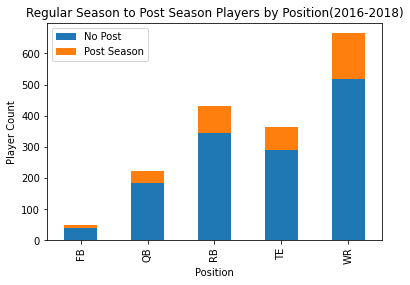

In [21]:

ax = stats_df.groupby(['position', 'Made_Roster']).size().unstack().plot(kind='bar', stacked=True)
ax.set_ylabel('Player Count')
ax.set_xlabel('Position')
ax.set_title('Regular Season to Post Season Players by Position(2016-2018)')
ax.legend(['No Post', 'Post Season'])

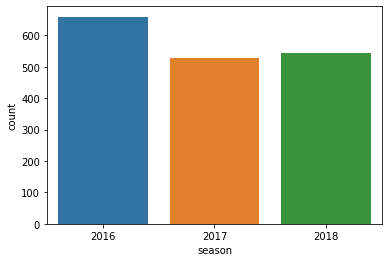

In [22]:
sns.countplot(x="season", data=stats_df);

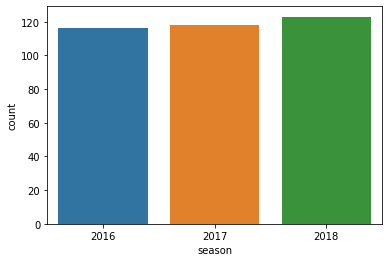

In [23]:
sns.countplot(x="season", data=stats_df[stats_df['Made_Roster'] == 1]);

C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\travis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax

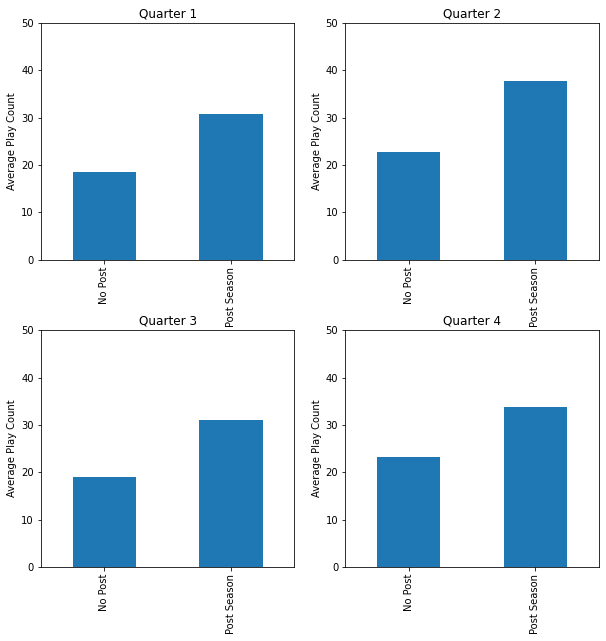

In [24]:
f = plt.figure(figsize=(10,10))

quarters = [1, 2, 3, 4]
for ii, jj in enumerate(quarters):
    plt.subplot(2,2,ii+1).set_ylim(0, 50)
    plt.title("Quarter " + str(jj))
    stats_df['Q' + str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.ylabel('Average Play Count')
    plt.xlabel('')
    plt.xticks([0,1], ['No Post', 'Post Season'])
    
f.subplots_adjust(hspace = .3)

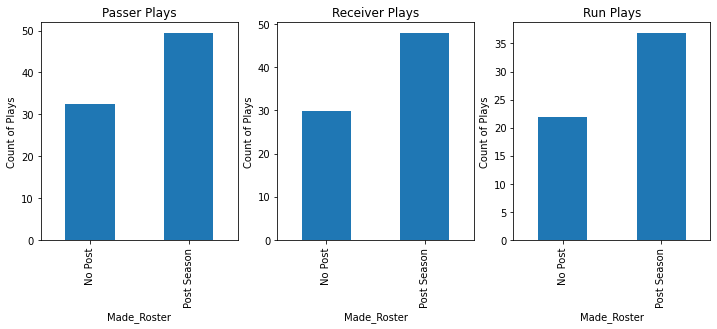

In [25]:
f = plt.figure(figsize=(12,4))

quarters = ['Passer', 'Receiver', 'Run']
for ii, jj in enumerate(quarters):
    plt.subplot(1,3,ii+1)
    plt.title(str(jj) + ' Plays')
    plt.ylabel('Count of Plays')
    plt.xlabel(' ')
    stats_df[str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.xticks([0,1], ['No Post', 'Post Season'])

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from statistics import mean

import warnings
warnings.filterwarnings('ignore')

In [27]:
X = stats_df.copy()
y = stats_df[['Made_Roster']]

ohe_df = pd.get_dummies(X.position)
X = pd.concat([X, ohe_df], axis=1).drop(columns=['Made_Roster',
                                                      'full_player_name', 'abbr_player_name', 'team', 'position', 'season'])

feature_names = list(X)

In [28]:
score = []

for ii in range(1, 31):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=ii)
    
    logreg = LogisticRegression(solver='saga')
    logreg.fit(X_train, y_train)
    score.append(logreg.score(X_test, y_test))
    
mean(score)

0.7816955684007707

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model_ftest = SelectKBest(score_func=f_classif, k='all')
model_ftest.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_classif at 0x00000157CD475168>)

In [30]:
ftest_scores = model_ftest.scores_
ftest_pvalues = model_ftest.pvalues_

In [31]:
descriptDf = pd.DataFrame()
descriptDf['feature'] = ['Success_Receive', 'receiving_yards', 'yards_after_catch', 'receiving_touchdown', 'touchdown', 'Receiver_Plays', 'Redzone', 'Success_Play', 'yards_gained', 'Q3_Plays', 'Q2_Plays']
descriptDf['description'] = ['Succesful Reception by Receiver', 'Total receiving yards for receiver by play', 'Yards gained after succesful reception', 'Total count of receiving touchdowns', 'Total count of touchdowns', 'Plays that targeted a receiver', 'Total plays inside opp. 20 yardline', 'Plays resulting in pos. yards', 'Total yards gained', 'Plays in third quarter possesing ball', 'Plays in second quarter possesing ball']
print(tabulate(descriptDf, tablefmt="github", headers="keys"))

|    | feature             | description                                |
|----|---------------------|--------------------------------------------|
|  0 | Success_Receive     | Succesful Reception by Receiver            |
|  1 | receiving_yards     | Total receiving yards for receiver by play |
|  2 | yards_after_catch   | Yards gained after succesful reception     |
|  3 | receiving_touchdown | Total count of receiving touchdowns        |
|  4 | touchdown           | Total count of touchdowns                  |
|  5 | Receiver_Plays      | Plays that targeted a receiver             |
|  6 | Redzone             | Total plays inside opp. 20 yardline        |
|  7 | Success_Play        | Plays resulting in pos. yards              |
|  8 | yards_gained        | Total yards gained                         |
|  9 | Q3_Plays            | Plays in third quarter possesing ball      |
| 10 | Q2_Plays            | Plays in second quarter possesing ball     |


In [32]:
ftest_all = pd.DataFrame(list(zip(feature_names, ftest_scores, ftest_pvalues)), columns=['feature', 'f value', 'p-value'])
pd.options.display.float_format = '{:.02f}'.format
ftest_all2 = ftest_all.sort_values('p-value').head(10)
print(tabulate(ftest_all2, tablefmt="github", headers="keys"))

|    | feature             |   f value |     p-value |
|----|---------------------|-----------|-------------|
| 35 | yards_after_catch   |   57.8926 | 5.54621e-14 |
| 27 | receiving_yards     |   48.8605 | 4.53299e-12 |
| 10 | Success_Receive     |   47.5684 | 8.5423e-12  |
|  5 | Receiver_Plays      |   41.4178 | 1.76819e-10 |
| 26 | receiving_touchdown |   41.1853 | 1.98367e-10 |
|  6 | Redzone             |   31.4269 | 2.56356e-08 |
| 32 | touchdown           |   30.5924 | 3.8986e-08  |
| 36 | yards_gained        |   28.6274 | 1.04864e-07 |
|  9 | Success_Play        |   27.1326 | 2.23132e-07 |
|  2 | Q2_Plays            |   23.8473 | 1.18257e-06 |


26


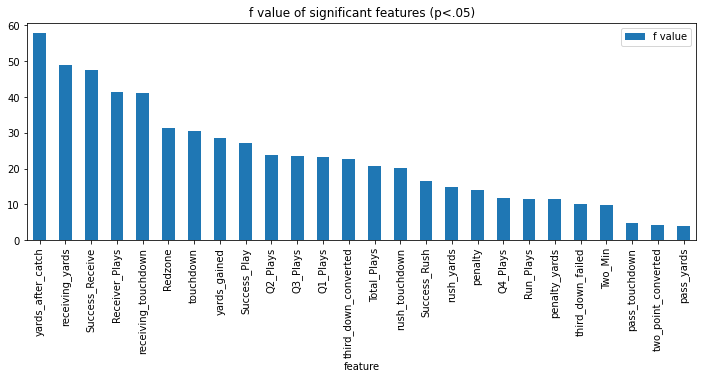

In [33]:
ftest_sig = ftest_all[ftest_all['p-value'] <= .05].sort_values('f value', ascending=False)
print(len(ftest_sig))
ftest_plot = ftest_sig.head(50)
ftest_plot.plot.bar(x='feature', y='f value', title='f value of significant features (p<.05)', figsize=(12,4))

In [34]:
StopWatch.stop("Data_Vis_16")
StopWatch.status("Data_Vis_16", True)

# 2009 - 2011 Regular Season Analysis

## Load Roster Data 

In [35]:
StopWatch.start("Data_Prep_09")

In [36]:
DATA_DIR = "C:/Users/travis/Dropbox (Arthroscopy Associa)/Travis/Desktop/IU Big Data Application/Final_Project_2"
datasets={}

In [37]:
reg_roster_2009 = load_data(os.path.join(DATA_DIR, f'reg_roster_2009.csv'), 'reg_roster_2009')
reg_roster_2009['Made_Roster'] = 0

post_roster_2009 = load_data(os.path.join(DATA_DIR, f'post_roster_2009.csv'), 'post_roster_2009')
post_roster_2009['Made_Roster'] = 1

roster_2009 = post_roster_2009.append(reg_roster_2009)

In [38]:
years = [2010, 2011]

In [39]:
roster_all = roster_2009.copy()

for ii in years:
    pre_name = 'reg_roster_' + str(ii)
    pre_df = load_data(os.path.join(DATA_DIR, f'{pre_name}.csv'), pre_name)
    #print(pre_df.shape)
    
    reg_name = 'post_roster_' + str(ii)
    reg_df = load_data(os.path.join(DATA_DIR, f'{reg_name}.csv'), reg_name)
    
    roster_df = pre_df.assign(Made_Roster=pre_df.gsis_id.isin(reg_df.gsis_id).astype(int))
    
    roster_all = roster_all.append(roster_df)
    #print(roster_all.shape)
    
roster_all = roster_all.drop(['season_type'], axis=1)

## Transform Play-By-Play Data 

In [40]:
years.append(2009)

In [41]:
columns = ['game_id', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 
           'goal_to_go', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained','air_yards', 'yards_after_catch', 
           'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
           'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception', 'penalty', 'fumble_lost',
           'touchdown', 'fumble', 'complete_pass', 'passer_player_id', 'receiver_player_id', 'rusher_player_id',
           'fumbled_1_player_id', 'penalty_player_id', 'penalty_yards',
           'unique_id', 'season', 'Two_Min', 'Redzone', 'Per_Yards_Gained', 'Success_Play']

In [42]:
pbp_all = pd.DataFrame(columns = columns)

for ii in years:
    pbp_name = 'reg_pbp_' + str(ii)
    pbp_df = load_data(os.path.join(DATA_DIR, f'{pbp_name}.csv'), pbp_name)
    
    #get unique ID for each play
    pbp_df['unique_id'] = pbp_df['play_id'].astype(str) + pbp_df['game_id'].astype(str)
    
    #add year of game
    pbp_df['season'] = ii
    
    #keep plays we are concerned with
    pbp_df = pbp_df[(pbp_df.play_type == 'pass') | (pbp_df.play_type == 'run')]
    
    #encode two point conversions
    two_conv_df = pbp_df[(pbp_df.two_point_conv_result == 'success')]
    pbp_df = pbp_df.assign(two_point_converted=pbp_df.unique_id.isin(two_conv_df.unique_id).astype(int))
    
    two_fail_df = pbp_df[(pbp_df.two_point_conv_result == 'failure')]
    pbp_df = pbp_df.assign(two_point_failed=pbp_df.unique_id.isin(two_fail_df.unique_id).astype(int))
    
    #flag plays in last two mins of a half
    two_min_df = pbp_df[(pbp_df.half_seconds_remaining <= 120)]
    pbp_df = pbp_df.assign(Two_Min=pbp_df.unique_id.isin(two_min_df.unique_id).astype(int))
    
    #flag red zone plays
    red_df = pbp_df[(pbp_df.yardline_100 <= 20)]
    pbp_df = pbp_df.assign(Redzone=pbp_df.unique_id.isin(red_df.unique_id).astype(int))
    
    
    # flag success rate using Football Outsider's varsity formula
    # https://www.footballoutsiders.com/info/glossary
    pbp_df['Per_Yards_Gained'] = pbp_df.yards_gained / pbp_df.ydstogo
    
    suc_fir_df = pbp_df[(pbp_df.down == 1) & (pbp_df.Per_Yards_Gained >= .5)]
    suc_sec_df = pbp_df[(pbp_df.down == 2) & (pbp_df.Per_Yards_Gained >= .7)]
    suc_thi_df = pbp_df[(pbp_df.down == 3) & (pbp_df.Per_Yards_Gained >= 1)]
    suc_fou_df = pbp_df[(pbp_df.down == 4) & (pbp_df.Per_Yards_Gained >= 1)]
    
    suc_all_df = pd.concat([suc_fir_df, suc_sec_df, suc_thi_df, suc_fou_df], axis=0, ignore_index=True)
    
    pbp_df = pbp_df.assign(Success_Play=pbp_df.unique_id.isin(suc_all_df.unique_id).astype(int))
    
    
    #prepare final dataframe
    pbp_df = pbp_df.fillna(0)
    
    pbp_all = pbp_all.append(pbp_df[columns])

## Combine All Data 

In [43]:
agg_cols = ['yards_gained', 'two_point_converted', 'two_point_failed', 'third_down_converted', 'third_down_failed',
            'fourth_down_converted', 'fourth_down_failed', 'touchdown', 'Two_Min', 'Redzone', 'Success_Play', 'Total_Plays',
            'Q1_Plays', 'Q2_Plays', 'Q3_Plays', 'Q4_Plays']

pass_cols = ['interception', 'incomplete_pass', 'complete_pass', 'air_yards', 'pass_yards', 'pass_touchdown', 
             'Success_Pass', 'Passer_Plays'] + agg_cols

rec_cols = ['yards_after_catch', 'receiving_yards', 'receiving_touchdown', 'Success_Receive', 'Receiver_Plays'] + agg_cols

rush_cols = ['rush_yards', 'rush_touchdown', 'Success_Rush', 'Run_Plays'] + agg_cols

pen_cols = ['penalty', 'penalty_yards']

fumb_cols = ['fumble_lost', 'fumble']

In [44]:
all_cols = pass_cols + rec_cols + rush_cols + pen_cols + fumb_cols
all_cols = list(set(all_cols))
all_cols = sorted(all_cols, key=str.lower)

In [45]:
stats_df = pd.DataFrame(columns = all_cols)

for ii in years:
    year_df = pbp_all[(pbp_all.season == ii)].copy()
    year_df['Total_Plays'] = 1
    
    #Add Plays in quarter    
    q1_df = year_df[(year_df.qtr == 1)]
    year_df = year_df.assign(Q1_Plays=year_df.unique_id.isin(q1_df.unique_id).astype(int))
    
    q2_df = year_df[(year_df.qtr == 2)]
    year_df = year_df.assign(Q2_Plays=year_df.unique_id.isin(q2_df.unique_id).astype(int))
    
    q3_df = year_df[(year_df.qtr == 3)]
    year_df = year_df.assign(Q3_Plays=year_df.unique_id.isin(q3_df.unique_id).astype(int))
    
    q4_df = year_df[(year_df.qtr == 4)]
    year_df = year_df.assign(Q4_Plays=year_df.unique_id.isin(q4_df.unique_id).astype(int))
    
    #assemble passing stats
    pass_df = year_df[(year_df.play_type == 'pass')]
    pass_df = pass_df.infer_objects()  
    pass_df['pass_yards'] = pass_df['yards_gained']
    pass_df['pass_touchdown'] = pass_df['touchdown']
    pass_df['Success_Pass'] = pass_df['Success_Play']
    pass_df['Passer_Plays'] = 1
    
    pass_df = pass_df.groupby('passer_player_id').sum()    
    pass_df = pass_df[pass_cols]
    pass_df.index.name = 'player_id'
    
    
    #assemble receiving stats
    rec_df = year_df[(year_df.play_type == 'pass')]
    rec_df = rec_df.infer_objects()
    rec_df['receiving_yards'] = rec_df['yards_gained']
    rec_df['receiving_touchdown'] = rec_df['touchdown']
    rec_df['Success_Receive'] = rec_df['Success_Play']
    rec_df['Receiver_Plays'] = 1
    
    rec_df = rec_df.groupby('receiver_player_id').sum()    
    rec_df = rec_df[rec_cols]
    
    rec_df.index.name = 'player_id'
    rec_df = rec_df.drop(rec_df.index[0])
    
    
    #assemble rushing stats
    rush_df = year_df[(year_df.play_type == 'run')]
    rush_df = rush_df.infer_objects()
    rush_df['rush_yards'] = rush_df['yards_gained']
    rush_df['rush_touchdown'] = rush_df['touchdown']
    rush_df['Success_Rush'] = rush_df['Success_Play']
    rush_df['Run_Plays'] = 1
    
    rush_df = rush_df.groupby('rusher_player_id').sum()    
    rush_df = rush_df[rush_cols]
    
    rush_df.index.name = 'player_id'
    
    
    #assemble penalty stats
    pen_df = year_df[(year_df.penalty == 1)]
    pen_df = pen_df.infer_objects()
    pen_df = pen_df.groupby('penalty_player_id').sum()    
    pen_df = pen_df[pen_cols]
    
    pen_df.index.name = 'player_id'
    pen_df = pen_df.drop(pen_df.index[0])
    
    
    #assemble fumble stats
    fumb_df = year_df[(year_df.fumble == 1)]
    fumb_df = fumb_df.infer_objects()
    
    fumb_df = fumb_df.groupby('fumbled_1_player_id').sum()    
    fumb_df = fumb_df[fumb_cols]
    
    fumb_df.index.name = 'player_id'
    
    
    #combine stats
    comb_df = pd.concat([pass_df, rec_df, rush_df, pen_df, fumb_df]).groupby(['player_id']).sum()
    
    
    #join in player information
    player_df = roster_all[(roster_all.season == ii)]
    
    player_df = player_df.set_index('gsis_id')
    player_df.index.name = 'player_id'
    
    comb_df = comb_df.join(player_df)    
    comb_df = comb_df.dropna(subset=['Made_Roster'])
    
    
    #join all data into final dataframe
    comb_df = comb_df.fillna(0)
   
    stats_df = stats_df.append(comb_df)

In [46]:
#change the display formats on numbers for simplicity
pd.options.display.float_format = '{:,.0f}'.format
stats_df['season'] = pd.to_numeric(stats_df['season'], downcast='integer')

In [47]:
print(len(stats_df))
stats_df.head()

1658


,Made_Roster,Passer_Plays,Q1_Plays,Q2_Plays,Q3_Plays,Q4_Plays,Receiver_Plays,Redzone,Run_Plays,Success_Pass,...,rush_yards,season,team,third_down_converted,third_down_failed,touchdown,two_point_converted,two_point_failed,yards_after_catch,yards_gained
00-0000865,0,52,8,22,15,11,0,6,4,19,...,30,2010,PIT,8,20,3,0,0,0,361
00-0001545,0,35,10,12,6,9,0,8,2,13,...,8,2010,JAC,3,7,3,0,0,0,224
00-0002110,0,14,2,9,2,1,0,1,0,7,...,0,2010,NYJ,3,3,3,0,0,0,110
00-0003035,0,0,0,0,2,0,2,1,0,0,...,0,2010,CHI,0,0,0,0,0,5,12
00-0003292,0,287,53,79,56,105,0,37,6,118,...,5,2010,TEN,29,54,15,1,0,0,"1,739"


In [48]:
StopWatch.stop("Data_Prep_09")
StopWatch.status("Data_Prep_09", True)

In [49]:
StopWatch.start("Data_Vis_09")

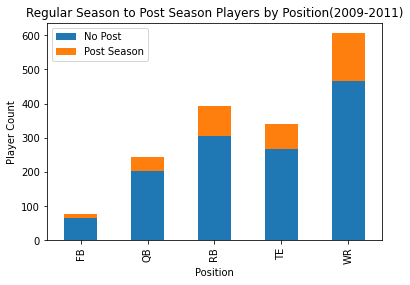

In [50]:
ax = stats_df.groupby(['position', 'Made_Roster']).size().unstack().plot(kind='bar', stacked=True)
ax.set_ylabel('Player Count')
ax.set_xlabel('Position')
ax.set_title('Regular Season to Post Season Players by Position(2009-2011)')
ax.legend(['No Post', 'Post Season'])

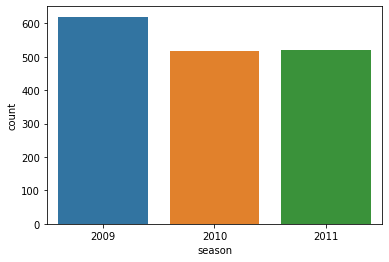

In [51]:
sns.countplot(x="season", data=stats_df);

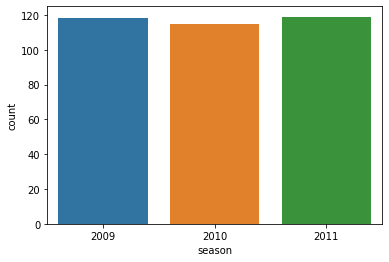

In [52]:
sns.countplot(x="season", data=stats_df[stats_df['Made_Roster'] == 1]);

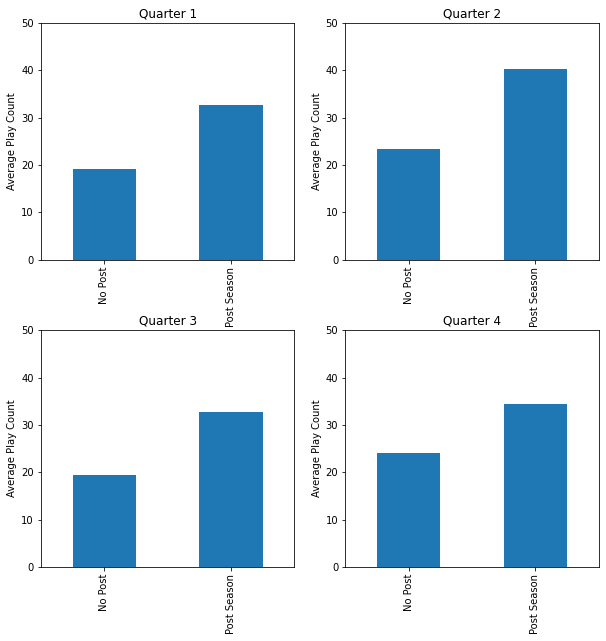

In [53]:
f = plt.figure(figsize=(10,10))

quarters = [1, 2, 3, 4]
for ii, jj in enumerate(quarters):
    plt.subplot(2,2,ii+1).set_ylim(0, 50)
    plt.title("Quarter " + str(jj))
    stats_df['Q' + str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.ylabel('Average Play Count')
    plt.xlabel('')
    plt.xticks([0,1], ['No Post', 'Post Season'])
    
f.subplots_adjust(hspace = .3)

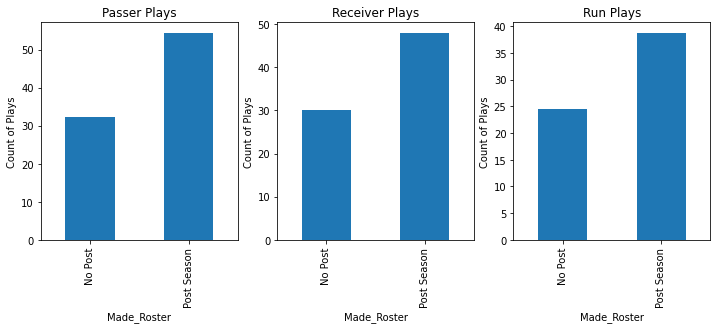

In [54]:
f = plt.figure(figsize=(12,4))

quarters = ['Passer', 'Receiver', 'Run']
for ii, jj in enumerate(quarters):
    plt.subplot(1,3,ii+1)
    plt.title(str(jj) + ' Plays')
    plt.ylabel('Count of Plays')
    plt.xlabel(' ')
    stats_df[str(jj) + '_Plays'].groupby(stats_df['Made_Roster']).mean().plot(kind='bar')
    plt.xticks([0,1], ['No Post', 'Post Season'])

In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from statistics import mean

import warnings
warnings.filterwarnings('ignore')

X = stats_df.copy()
y = stats_df[['Made_Roster']]

ohe_df = pd.get_dummies(X.position)
X = pd.concat([X, ohe_df], axis=1).drop(columns=['Made_Roster',
                                                      'full_player_name', 'abbr_player_name', 'team', 'position', 'season'])

feature_names = list(X)

score = []

for ii in range(1, 31):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=ii)
    
    logreg = LogisticRegression(solver='saga')
    logreg.fit(X_train, y_train)
    score.append(logreg.score(X_test, y_test))
    
mean(score)

0.7781124497991968

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model_ftest = SelectKBest(score_func=f_classif, k='all')
model_ftest.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_classif at 0x00000157CD475168>)

In [57]:
ftest_scores = model_ftest.scores_
ftest_pvalues = model_ftest.pvalues_

In [58]:
ftest_all = pd.DataFrame(list(zip(feature_names, ftest_scores, ftest_pvalues)), columns=['feature', 'f value', 'p-value'])
pd.options.display.float_format = '{:.02f}'.format
ftest_all2 = ftest_all.sort_values('p-value').head(10)
print(tabulate(ftest_all2, tablefmt="github", headers="keys"))

|    | feature             |   f value |     p-value |
|----|---------------------|-----------|-------------|
| 10 | Success_Receive     |   63.0432 | 4.75241e-15 |
| 27 | receiving_yards     |   58.3434 | 4.59294e-14 |
| 35 | yards_after_catch   |   54.2878 | 3.28341e-13 |
| 26 | receiving_touchdown |   51.5976 | 1.21655e-12 |
| 32 | touchdown           |   47.8719 | 7.51357e-12 |
|  5 | Receiver_Plays      |   47.5658 | 8.729e-12   |
|  6 | Redzone             |   44.4738 | 3.98292e-11 |
|  9 | Success_Play        |   40.6625 | 2.60862e-10 |
| 36 | yards_gained        |   39.8166 | 3.96393e-10 |
|  3 | Q3_Plays            |   33.2479 | 1.03979e-08 |


31


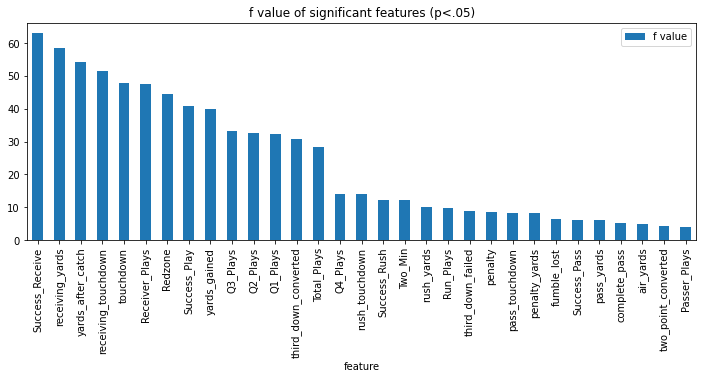

In [59]:
ftest_sig = ftest_all[ftest_all['p-value'] <= .05].sort_values('f value', ascending=False)
print(len(ftest_sig))
ftest_plot = ftest_sig.head(50)
ftest_plot.plot.bar(x='feature', y='f value', title='f value of significant features (p<.05)', figsize=(12,4))

In [60]:
StopWatch.stop("Data_Vis_09")
StopWatch.status("Data_Vis_09", True)

In [61]:
StopWatch.stop("project")

In [62]:
StopWatch.status("project", True)

In [63]:
StopWatch.benchmark()


+------------------+--------------------------------------------------------------------+
| Attribute        | Value                                                              |
|------------------+--------------------------------------------------------------------|
| cpu_count        | 8                                                                  |
| mem.available    | 9.2 GiB                                                            |
| mem.free         | 9.2 GiB                                                            |
| mem.percent      | 41.5 %                                                             |
| mem.total        | 15.7 GiB                                                           |
| mem.used         | 6.5 GiB                                                            |
| platform.version | ('10', '10.0.18362', 'SP0', '')                                    |
| python           | 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)] |
| python.